In [1]:
import rbi 
from rbi.utils.autograd_tools import batch_jacobian
import torch
from rbibm.plots.styles import use_style

import matplotlib.pyplot as plt

torch.manual_seed(1)

In [2]:
def phi(x, N=500):
    inducing_points = torch.linspace(-4,4, N)
    return torch.stack([torch.exp(-2*torch.pow(x - x_i,2)) for x_i in inducing_points], dim=-1).squeeze()
    #return torch.stack([x**i for i in range(0, N + 1)], dim=-1).squeeze()

In [3]:
X = torch.randn((40, 1)).T*2
phi_X = phi(X).T
Y = torch.sin(X) + 0.1*torch.randn_like(X)#*X**2

Js = batch_jacobian(phi,torch.randn((1000,1)).T*2)

In [4]:
omega = torch.bmm(Js, Js.transpose(-2,-1)).squeeze( )/ Js.shape[-1]

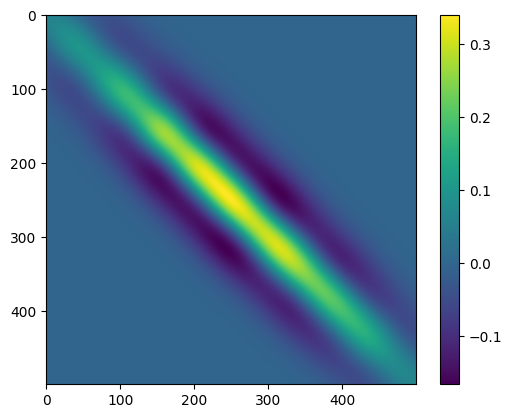

In [5]:
plt.imshow(omega)
plt.colorbar()

(-4.0, 4.0)

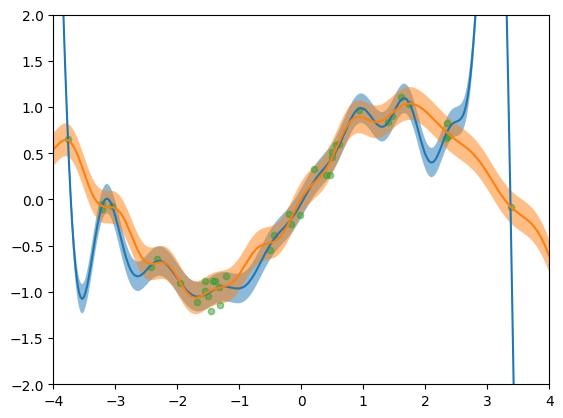

In [6]:
x = torch.linspace(-5,5, 10000)

beta = 0.1
w = torch.linalg.solve(phi_X@phi_X.T , (Y@phi_X.T).T).T
w_ridge = torch.linalg.solve(phi_X@phi_X.T + beta*torch.eye(omega.shape[0]) , (Y@phi_X.T).T).T
w_FIM =  torch.linalg.solve(phi_X@phi_X.T + 2*beta*omega , (Y@phi_X.T).T).T



y = w@phi(x.reshape(-1,1)).T
y_ridge = w_ridge@phi(x.reshape(-1,1)).T
y_fim = w_FIM@phi(x.reshape(-1,1)).T

y_hat = w@phi(X).T
cov = torch.squeeze(1/Y.numel()*(y_hat - Y)@(y_hat - Y).T)
cov_fim = cov + 1/Y.numel()*torch.squeeze(beta*w_FIM@omega@w_FIM.T)

plt.plot(x.squeeze(), y.squeeze())
plt.fill_between(x.squeeze(), y.squeeze()-cov.sqrt()*2, y.squeeze() + cov.sqrt()*2, alpha=0.5)
#plt.plot(x.squeeze(), y_ridge.squeeze())
plt.plot(x.squeeze(), y_fim.squeeze())
plt.fill_between(x.squeeze(), y_fim.squeeze()-cov_fim.sqrt()*2, y_fim.squeeze() + cov_fim.sqrt()*2, alpha=0.5)
plt.scatter(X.squeeze(), Y.squeeze(), alpha=0.5, s=20)

plt.ylim(-2, 2)
plt.xlim(-4,4)

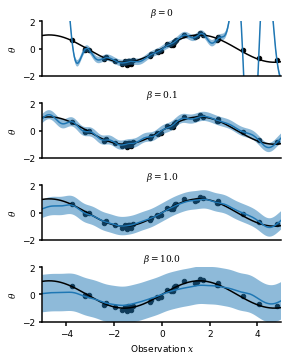

In [7]:
with use_style("pyloric"):
    fig, axes = plt.subplots(4, 1, figsize=(4,5))

    w = torch.linalg.solve(phi_X@phi_X.T , (Y@phi_X.T).T).T
    y = w@phi(x.reshape(-1,1)).T
    y_hat = w@phi(X).T
    cov = torch.squeeze(1/Y.numel()*(y_hat - Y)@(y_hat - Y).T)
    axes[0].scatter(X.squeeze(), Y.squeeze(), s=20, color="black")
    axes[0].plot(x.squeeze(), torch.sin(x).squeeze(), color="black")
    axes[0].plot(x.squeeze(), y.squeeze())
    axes[0].fill_between(x.squeeze(), y.squeeze()-cov.sqrt()*3, y.squeeze() + cov.sqrt()*3, alpha=0.5)
    axes[0].set_xlim(-5,5)
    axes[0].set_ylim(-2,2)
    axes[0].set_xticks([])
    axes[0].set_title(r"$\beta = 0$")
    axes[0].set_ylabel(r"$\theta$")
    i = 1
    for beta in [0.1, 1., 10.]:
        w_FIM =  torch.linalg.solve(phi_X@phi_X.T + 2*beta*omega , (Y@phi_X.T).T).T
        y_fim = w_FIM@phi(x.reshape(-1,1)).T
        cov_fim = cov + 1/Y.numel()*torch.squeeze(4*beta*w_FIM@omega@w_FIM.T)
        axes[i].scatter(X.squeeze(), Y.squeeze(), s=20, color="black")
        axes[i].plot(x.squeeze(), torch.sin(x).squeeze(), color="black")
        axes[i].plot(x.squeeze(), y_fim.squeeze())
        axes[i].fill_between(x.squeeze(), y_fim.squeeze()-cov_fim.sqrt()*3, y_fim.squeeze() + cov_fim.sqrt()*3, alpha=0.5)
        axes[i].set_xlim(-5,5)
        axes[i].set_ylim(-2,2)
        axes[i].set_title(rf"$\beta={beta}$")
        axes[i].set_ylabel(rf"$\theta$")
        if i != 3:
            axes[i].set_xticks([])
        i +=1
    axes[3].set_xlabel(r"Observation $x$")
    
    fig.tight_layout()
    fig.savefig("appendix_FIM_reg.svg")
